In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import recall_score
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler, OrdinalEncoder, RobustScaler,\
                                    OneHotEncoder,MaxAbsScaler, PolynomialFeatures, LabelEncoder, PowerTransformer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import ConfusionMatrixDisplay, plot_confusion_matrix, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

RANDOM_STATE = 0

%matplotlib inline

In [2]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv").dropna()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658064 entries, 0 to 658063
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      658064 non-null  int64 
 1   name    658064 non-null  object
 2   groups  658064 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 15.1+ MB


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282227 entries, 0 to 282226
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      282227 non-null  int64 
 1   name    282227 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.3+ MB


## Рассмотрим датасет по ближе

In [29]:
df.head(3)

,id,name,groups,len name
0,2442477,БЗМЖ Молоко ультропаст.Вкуснотеево900гр.3.2%ПЭТ/б,3,49
1,1564599,"15.6"" Ноутбук Acer Nitro 5 (AN515-54-58LL)(FHD...",10,100
2,841848,ЖЕВ.РЕЗИНКА ОРБИТ НЕЖНАЯ МЯТА XX 46153708,10,41


In [5]:
df.head(3)

,id,name,groups
0,1034,ШОК-ЦЕНА Пена д/душа/бритья КУППЕР 200 мл АКС,10
1,1035,Мин.вода Нагутская №26 0.5л,0
2,1036,Пельмени Домашние вес ПО Прямицино.,10


Добавим пару новых столбцов

In [3]:
df_all = pd.concat([df, df_test])
df_all["len_name"] = df_all["name"].str.len()

Векторизация

In [4]:
%%time
tfidf_char = TfidfVectorizer(analyzer='char', ngram_range=(1, 5), min_df=10, max_df=0.8)
tfidf_ngram = TfidfVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.8)
char_csr = tfidf_char.fit_transform(df_all['name'])
ngram_csr = tfidf_ngram.fit_transform(df_all['name'])

Wall time: 7min 29s


In [5]:
char_csr

<940291x531057 sparse matrix of type '<class 'numpy.float64'>'
	with 144430996 stored elements in Compressed Sparse Row format>

In [6]:
ngram_csr

<940291x90627 sparse matrix of type '<class 'numpy.float64'>'
	with 7132592 stored elements in Compressed Sparse Row format>

Распределение столбца 'len_name'

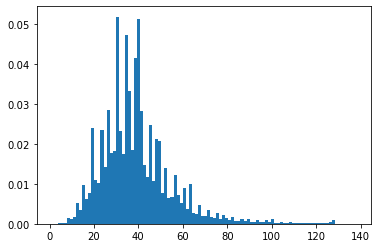

In [56]:
plt.hist(df_all['len_name'], bins=100, density=True);

Преобразование столбца len_name к нормальному распределению

In [7]:
sca = PowerTransformer()
pow_sca = sca.fit_transform(df_all['len_name'].values.reshape(-1, 1))

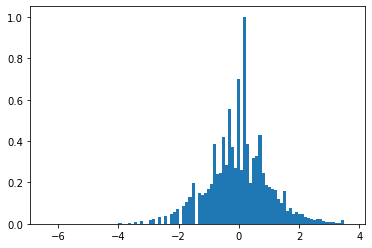

In [57]:
plt.hist(pow_sca, bins=100, density=True);

Стекируем все данные в разреженный формат

In [ ]:
csr_all = hstack([csr_matrix(pow_sca), char_csr, ngram_csr])

## Выделим выборки

In [9]:
X = csr_all[:df.shape[0]]
y = df['groups']
test = csr_all[df.shape[0]:]

Создадим словарь для балансировки классов (приведем значения к 3-ему мажоритарному классу)

In [ ]:
def create_smote_dict(y_train):
    y_sort = y_train.value_counts().sort_values()
    label_for_balanced = y_sort.index[:-3]
    value_for_balanced = y_sort.iloc[-3]
    
    return dict(zip(label_for_balanced, [value_for_balanced]*len(label_for_balanced)))

smote_dict = create_smote_dict(y_train_)

# Добавим, дополнительно, значения 6-го класса, так как он является наиболее трудноопределяемым
smote_dict[6] *= 3
smote_dict

In [26]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.3, random_state=42)

Wall time: 12.9 s


In [34]:
y_train_.value_counts()

10    352056
9      29537
4      19282
0      15078
3      14563
1      11986
7       8407
6       7012
2       2723
Name: groups, dtype: int64

In [69]:
%%time

smote = SMOTE(sampling_strategy=smote_dict, random_state=RANDOM_STATE)

X_train, y_train = smote.fit_resample(X_train_, y_train_)

Wall time: 3min 34s


In [ ]:
y_train.value_counts()

## Обучение тренировочной модели

In [70]:
clf = LogisticRegression(solver='liblinear', C=1000)

In [71]:
%%time
clf.fit(X_train, y_train)

Wall time: 35min 54s


LogisticRegression(C=1000, solver='liblinear')

## Оценка точности

In [72]:
pred = clf.predict(X_test)

Recall score: 0.9808254131483278


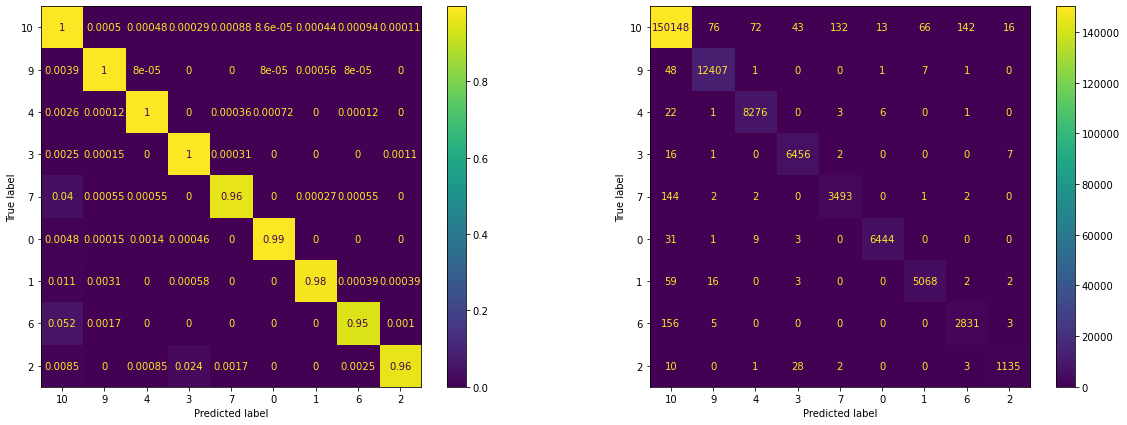

In [73]:
def view_test(true_labels, pred_labels, labels_train):
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    for i in range(2):
        cm = confusion_matrix(true_labels, pred_labels, labels=labels_train, normalize=['true', None][i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_train)
        disp.plot(ax=axes[i]);


labels_train = y_train.unique()

view_test(y_test, pred, labels_train)

score = recall_score(y_test, pred, average='macro')
print("Recall score:", score)

## Обучение модели на всех данных

In [ ]:
y.value_counts()

In [81]:
smote_dict_ = create_smote_dict(y)
smote_dict_[6] *= 3
smote_dict_

{2: 27591, 6: 82773, 7: 27591, 1: 27591, 3: 27591, 0: 27591}

In [ ]:
%%time

smote = SMOTE(sampling_strategy=smote_dict_, random_state=RANDOM_STATE)

X_, y_ = smote.fit_resample(X, y)

In [ ]:
y_.value_counts()

In [15]:
%%time
clf.fit(X_, y_)

Wall time: 50min 1s


LogisticRegression(C=1000, solver='liblinear')

In [ ]:
pred_ = clf.predict(test)

In [18]:
sub = df_test[['id']].copy()
sub['groups'] = pred_.astype(int)

In [20]:
sub.to_csv('submit.csv', index=False)